# Visualising the data and the output

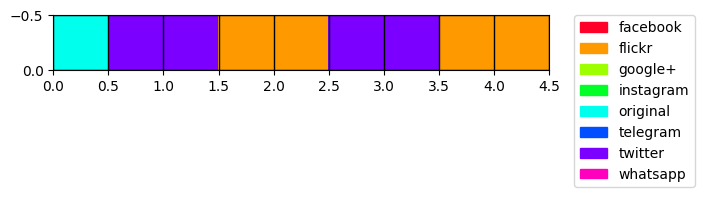

array([[4, 6, 1, 6, 1],
       [5, 7, 0, 2, 4],
       [6, 2, 2, 2, 2],
       [2, 5, 2, 7, 5],
       [2, 5, 4, 3, 3]])

In [36]:
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.patches as mpatches

a = np.random.randint(0, 8, (5,5))
# fig, ax = plt.subplots()
fig, ax = plt.subplots()
im = plt.imshow(a, cmap='gist_rainbow')

ax.grid(which='major', color='black', linestyle='-', linewidth=1)

values = [i for i in range(8)]

colors = [ im.cmap(im.norm(value)) for value in values]

classes = [
    'facebook',
    'flickr',
    'google+',
    'instagram',
    'original',
    'telegram',
    'twitter', 
    'whatsapp'
]

patches = [
    mpatches.Patch(color=colors[i], label=classes[i]) for i in range(len(classes))
]

# patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]

plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )


# ax.set_xlim(xmin=0)
plt.show()
a